In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## show images

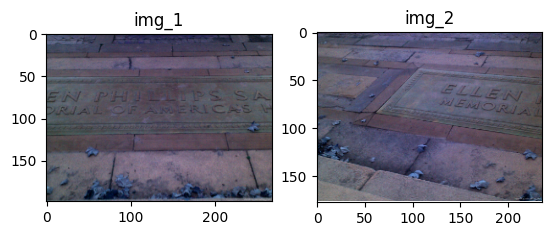

In [40]:
ori_img_1 = cv2.imread("right.jpeg")
ori_img_2 = cv2.imread("left.jpeg")
img_1 = cv2.resize(ori_img_1.copy(),(0,0),fx=0.2,fy=0.2)
img_2 = cv2.resize(ori_img_2.copy(),(0,0),fx=0.2,fy=0.2)
# ori_img_1 = cv2.imread("img_1.png")
# ori_img_2 = cv2.imread("img_2.png")
# img_1 = cv2.resize(ori_img_1.copy(),(0,0),fx=1.0,fy=1.0)
# img_2 = cv2.resize(ori_img_2.copy(),(0,0),fx=1.0,fy=1.0)                                                                                                                                                    
plt.subplot(1, 2, 1)
plt.title("img_1")
plt.imshow(ori_img_1)
plt.subplot(1, 2, 2)
plt.title("img_2")
plt.imshow(ori_img_2)
plt.show()

## detect features

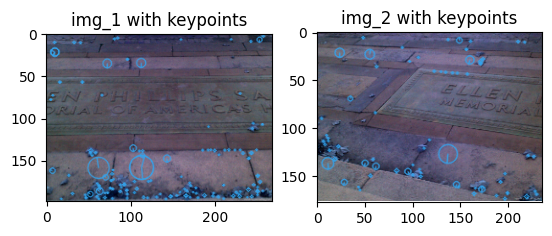

In [41]:
sift = cv2.SIFT_create()
# img_1 = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
kps_1, des_1 = sift.detectAndCompute(img_1, None)
out_1 = cv2.drawKeypoints(image=img_1, outImage=img_1.copy(), keypoints=kps_1,
                          flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
                          color=(51, 163, 236))
# img_2 = cv2.cvtColor(img_2, cv2.COLOR_RGB2GRAY)
kps_2, des_2 = sift.detectAndCompute(img_2, None)
out_2 = cv2.drawKeypoints(image=img_2, outImage=img_2.copy(), keypoints=kps_2,
                          flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
                          color=(51, 163, 236))
plt.subplot(1, 2, 1)
plt.title("img_1 with keypoints")
plt.imshow(out_1)
plt.subplot(1, 2, 2)
plt.title("img_2 with keypoints")
plt.imshow(out_2)
plt.show()


## match features

match points nums: 150


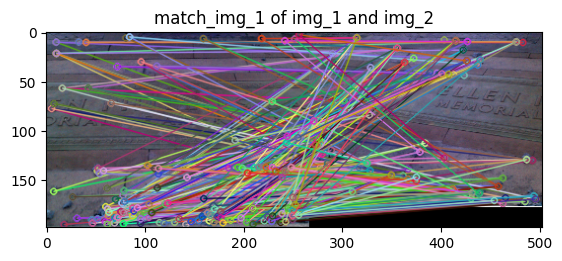

In [42]:
matcher = cv2.BFMatcher()
matches = matcher.knnMatch(des_1, des_2, 2)
print("match points nums: {}".format(len(matches)))
h1, w1 = img_1.shape[:2]
h2, w2 = img_2.shape[:2]
match_img_1 = np.zeros((max(h1, h2), w1 + w2, 3), np.uint8)
match_img_1[:h1, :w1] = img_1
match_img_1[:h2, w1:w1+w2] = img_2
match_img_1 = cv2.drawMatchesKnn(img_1, kps_1, img_2, kps_2, matches, match_img_1)
plt.title("match_img_1 of img_1 and img_2")
plt.imshow(match_img_1)
plt.show()


*发现有很多误匹配点，使用距离阈值进行过滤*

good match points nums: 5


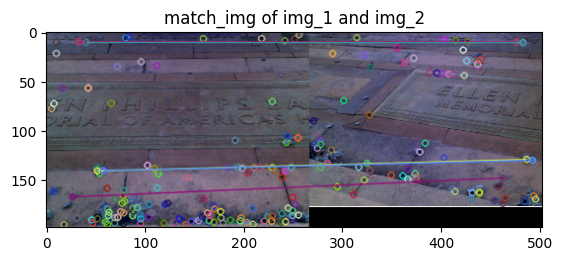

In [43]:
good_matches = []
for m, n in matches:
    if m.distance < 0.5*n.distance: # 如果第一个邻近距离比第二个邻近距离的0.5倍小，则保留
        good_matches.append(m)
print("good match points nums: {}".format(len(good_matches)))
match_img_2 = np.zeros((max(h1, h2), w1 + w2, 3), np.uint8)
match_img_2[:h1, :w1] = img_1
match_img_2[:h2, w1:w1+w2] = img_2
match_img_2 = cv2.drawMatches(img_1, kps_1, img_2, kps_2, good_matches, match_img_2)
plt.title("match_img of img_1 and img_2")
plt.imshow(match_img_2)
plt.show()

## image stitching

*由于简单基于欧氏距离测度的SIFT特征匹配中存在许多误匹配的点，这些误匹配点将严重影响后面变换模型参数的解算，因此需要利用鲁棒估计的方法将这些误匹配的点剔除，在这里鲁棒估计我们使用最常规的**RANSAC**方法。*

In [44]:
kps_1_pt = np.float32([kp.pt for kp in kps_1])
kps_2_pt = np.float32([kp.pt for kp in kps_2])
matches_id = []
for m in matches:
    if len(m) == 2 and m[0].distance < m[1].distance * 0.5:
            matches_id.append((m[0].queryIdx, m[0].trainIdx))
pts_1 = np.float32([kps_1_pt[i] for (i, _) in matches_id])
pts_2 = np.float32([kps_2_pt[i] for (_, i) in matches_id])
# 计算变换矩阵(采用ransac算法从pts中选择一部分点)
H, status = cv2.findHomography(pts_1, pts_2, cv2.RANSAC, 4.0)
print(H)

[[ 6.26349723e-01 -4.22087853e-02  1.81548940e+02]
 [ 1.17278515e-02  8.58612508e-01  6.28299195e-01]
 [-1.16037185e-03  3.91313704e-05  1.00000000e+00]]


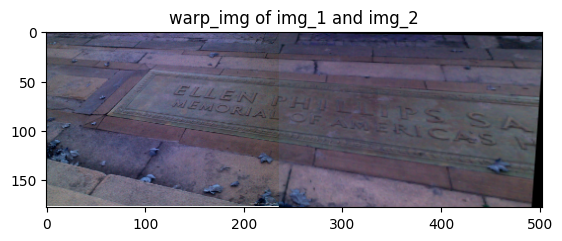

In [45]:
# 将图片1进行视角变换，warp_img是变换后图片
warp_img = cv2.warpPerspective(img_1, H, (img_1.shape[1] + img_2.shape[1], img_2.shape[0]))
warp_img_copy = warp_img.copy()
# 将图片2传入warp_img图片最左端
warp_img[0:img_2.shape[0], 0:img_2.shape[1]] = img_2
plt.title("warp_img of img_1 and img_2")
plt.imshow(warp_img)
plt.show()

*可以发现直接拼接虽然可以拼接，但是在拼接的地方会有一条很明显的缝隙，且有黑边*

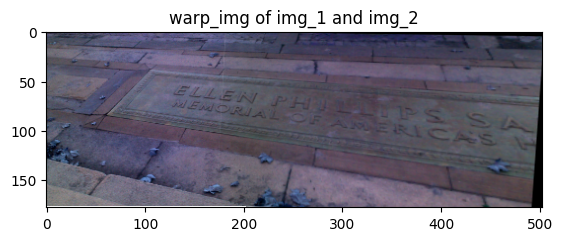

In [46]:
rows, cols = img_2.shape[:2]
# print(rows)
# print(cols)
for col in range(0, cols):
    # 开始重叠的最左端
    if img_2[:, col].any() and warp_img_copy[:, col].any():
        left = col
        # print(left)
        break
for col in range(cols-1, 0, -1):
    # 重叠的最右一列
    if img_2[:, col].any() and warp_img_copy[:, col].any():
        right = col
        # print(right)
        break
# 加权处理
res = np.zeros([rows, cols, 3], np.uint8)
for row in range(0, rows):
    for col in range(0, cols):
        if not img_2[row, col].any():  # 如果没有原图，用旋转的填充
            res[row, col] = warp_img_copy[row, col]
        elif not warp_img_copy[row, col].any():
            res[row, col] = img_2[row, col]
        else:
            srcImgLen = float(abs(col - left))
            testImgLen = float(abs(col - right))
            alpha = srcImgLen / (srcImgLen + testImgLen)
            res[row, col] = np.clip(img_2[row, col] * (1 - alpha) + warp_img_copy[row, col] * alpha, 0, 255)
warp_img[0:img_2.shape[0], 0:img_2.shape[1]] = res
plt.title("warp_img of img_1 and img_2")
plt.imshow(warp_img)
plt.show()


(178, 503)


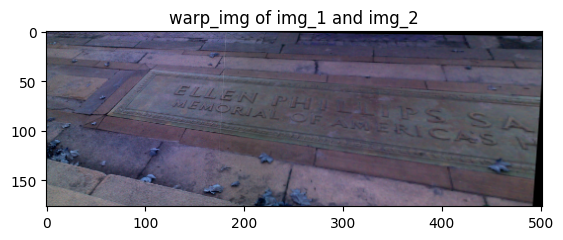

In [47]:
def change_size(image):
    img = cv2.medianBlur(image, 5)  # 中值滤波，去除黑色边际中可能含有的噪声干扰
    b = cv2.threshold(img, 15, 255, cv2.THRESH_BINARY)  # 调整裁剪效果
    binary_image = b[1]  # 二值图--具有三通道
    binary_image = cv2.cvtColor(binary_image, cv2.COLOR_BGR2GRAY)
    print(binary_image.shape)  # 改为单通道

    indexes = np.where(binary_image == 255)  # 提取白色像素点的坐标

    left = min(indexes[0])  # 左边界
    right = max(indexes[0])  # 右边界
    width = right - left  # 宽度
    bottom = min(indexes[1])  # 底部
    top = max(indexes[1])  # 顶部
    height = top - bottom  # 高度

    pre1_picture = image[left:left + width, bottom:bottom + height]  # 图片截取
    return pre1_picture  # 返回图片数据

stitch_img = change_size(warp_img)
plt.title("warp_img of img_1 and img_2")
plt.imshow(stitch_img)
plt.show()